In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

all_df = pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/adaptive_speak_eval_22june/adaptive_speak_eval_all_v15.csv', on_bad_lines='skip')
print('target domain   :', all_df['target domain'].unique())
print('listener domain :', all_df['listener domain'].unique())
print('simulator domain:', all_df['simulator domain'].unique())

df = pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/adaptive_speak_eval_22june/adaptive_speak_eval_food_v2.csv')
print('target domain   :', df['target domain'].unique())
print('listener domain :', df['listener domain'].unique())
print('simulator domain:', df['simulator domain'].unique())

In [2]:
_df = pd.concat([
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/appliances.csv'),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/food.csv'),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/indoor.csv'),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/outdoor.csv'),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/vehicles.csv')
])

# _df = pd.read_csv(
    # '/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/all.csv')
    # ,
    # error_bad_lines=False, warn_bad_lines=True)


In [84]:
_df

,Unnamed: 0,target domain,listener domain,simulator domain,target img idx,img path #0,img path #1,img path #2,img path #3,img path #4,...,sim_list_acc14,sim_list_acc15,sim_list_acc16,sim_list_acc17,sim_list_acc18,sim_list_acc19,sim_list_acc20,sim_list_acc21,sim_list_acc22,sim_list_acc23
0,0,food,appliances,appliances,0,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,1,food,appliances,appliances,5,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2,food,appliances,appliances,5,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,3,food,appliances,appliances,1,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,4,food,appliances,appliances,4,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4743,4743,outdoor,vehicles,vehicles,5,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4744,4744,outdoor,vehicles,vehicles,5,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4745,4745,outdoor,vehicles,vehicles,0,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4746,4746,outdoor,vehicles,vehicles,4,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [3]:
# pd.to_numeric(df['target domain'], errors='coerce')

print('target domain   :', _df['target domain'].unique())
print('listener domain :', _df['listener domain'].unique())
print('simulator domain:', _df['simulator domain'].unique())
# _df = _df.dropna()
print('Data points:', len(_df))

_df = _df[_df['listener domain'] != 'all']
_df = _df[_df['simulator domain'] != 'all']

id_df = _df[(_df['target domain'] == _df['listener domain'])]
ood_df = _df[(_df['target domain'] != _df['listener domain'])]

# df = ood_df
# df.head(2)
print('OOD Data points:', len(_df))

target domain   : ['food' 'vehicles' 'outdoor' 'indoor' 'appliances']
listener domain : ['appliances' 'food' 'indoor' 'outdoor' 'vehicles']
simulator domain: ['appliances' 'food' 'indoor' 'outdoor' 'vehicles']
Data points: 23740
OOD Data points: 23740


In [9]:
N_STEPS = 24
print('Representations: how many change?')
for n in range(N_STEPS):
    print(f's{n}:', len(df[df['original h0'] != df[f'adapted h0 s{n}']]), '/', len(df))

print('\nUtterances: how many change?')
for n in range(N_STEPS):
#     print(f's{n}:', len(df[df['original utt'] != df[f'adapted utt s{n}']]), '/', len(df))
    if n > 0:
        print(f's{n-1} -> s{n}:', len(df[df[f'adapted utt s{n}'] != df[f'adapted utt s{n-1}']]), '/', len(df))
    else:
        print(f'orig -> s{n}:', len(df[df[f'adapted utt s{n}'] != df['original utt']]), '/', len(df))

Representations: how many change?


NameError: name 'df' is not defined

## Diagnostic classification

In [4]:
CLF_TYPE = 'logistic'


In [5]:
def train_and_classify(X, Y, classifier_type='LR'):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=1)
    # print(f'X_train: {X_train.shape}  X_test: {X_test.shape}  Y_train: {Y_train.shape}  Y_test: {Y_test.shape}')

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if classifier_type == 'MLP':
        clf = MLPClassifier(random_state=1, max_iter=10000).fit(X_train_scaled, Y_train)
    elif classifier_type == 'logistic':
        clf = LogisticRegression(random_state=1, max_iter=10000).fit(X_train_scaled, Y_train)
    # elif classifier_type == 'linear':
    #     clf = LinearRegression().fit(X_train_scaled, Y_train)
    else:
        raise ValueError()

    Y_pred = clf.predict(X_test_scaled)

    return classification_report(Y_test, Y_pred), clf, scaler

In [6]:
def classify(X, Y, classifier, scaler):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=1)
    # print(f'X_train: {X_train.shape}  X_test: {X_test.shape}  Y_train: {Y_train.shape}  Y_test: {Y_test.shape}')

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    Y_pred = classifier.predict(X_test_scaled)

    return classification_report(Y_test, Y_pred)

# Is the domain of the target image encoded in $h_0$?

### Predict target domain from non-adapted hidden representation

In [7]:
X, Y = [], []

for _, row in _df.iterrows():
    X.append(eval(row['original h0']))
    Y.append(row['target domain'])

X, Y = np.array(X), np.array(Y)

report, target_classifier, target_scaler = train_and_classify(X, Y, CLF_TYPE)
print(report)

              precision    recall  f1-score   support

  appliances       1.00      1.00      1.00       676
        food       1.00      1.00      1.00       861
      indoor       1.00      1.00      1.00      1880
     outdoor       1.00      1.00      1.00      2601
    vehicles       1.00      1.00      1.00      1104

    accuracy                           1.00      7122
   macro avg       1.00      1.00      1.00      7122
weighted avg       1.00      1.00      1.00      7122



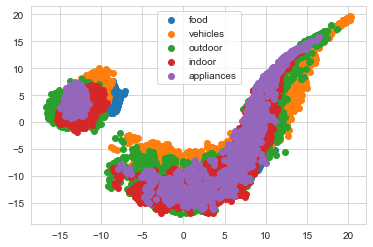

In [63]:
pca = PCA(2)
scaler = preprocessing.StandardScaler().fit(X)
X_2dim = pca.fit_transform(scaler.transform(X))

for l in df['target domain'].unique():
    plt.scatter(X_2dim[Y == l, 0], X_2dim[Y == l, 1], label=l)
plt.legend()
plt.show()

### Predict _target_ domain from adapted hidden representation (probe trained on non-adapted)

In [14]:
accs = []
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []

    for _, row in ood_df.iterrows():
        try:
            x = eval(row[f'adapted h0 s{step}'])
        except TypeError:
            x = int(row[f'adapted h0 s{step}'])
        if x != -1:
            X.append(x)
            Y.append(row['target domain'])
    try:
        tmp_report = classify(X, Y, target_classifier, target_scaler)
        accs.append(float(tmp_report.split('accuracy')[1].split()[0]))
    except ValueError:
        print("Not enough data to classify")
#     print(tmp_report)


#     pca = PCA(2)
#     scaler = preprocessing.StandardScaler().fit(X)
#     X_2dim = pca.fit_transform(scaler.transform(X))

#     for l in df['target domain'].unique():
#         plt.scatter(X_2dim[Y == l, 0], X_2dim[Y == l, 1], label=l)
#     plt.legend()
#     plt.show()

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23


Text(0.5, 0, 'Adaptation step')

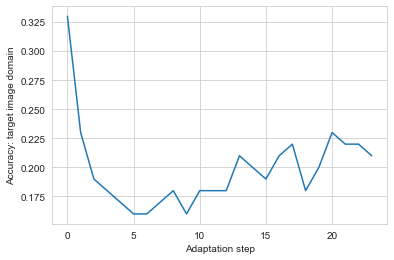

In [15]:
plt.plot(range(N_STEPS), accs)
# plt.title('Random embeddings')
plt.ylabel('Accuracy: target image domain')
plt.xlabel('Adaptation step')

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23


Text(0.5, 0, 'Adaptation step')

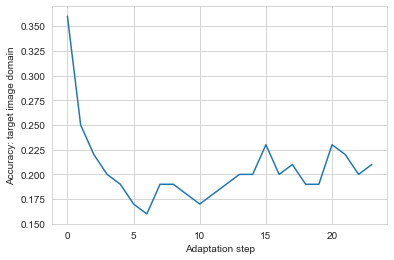

In [18]:
accs = []
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []

    for _, row in _df.iterrows():
        try:
            x = eval(row[f'adapted h0 s{step}'])
        except TypeError:
            x = int(row[f'adapted h0 s{step}'])
        if x != -1:
            X.append(x)
            Y.append(row['target domain'])
    try:
        tmp_report = classify(X, Y, target_classifier, target_scaler)
        accs.append(float(tmp_report.split('accuracy')[1].split()[0]))
    except ValueError:
        print("Not enough data to classify")
#     print(tmp_report)


plt.plot(range(N_STEPS), accs)
# plt.title('Random embeddings')
plt.ylabel('Accuracy: target image domain')
plt.xlabel('Adaptation step')

### Predict _target_ domain from adapted hidden representation (probe retrained at each step)

In [21]:
accs = []
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []

    for _, row in ood_df.iterrows():
        try:
            x = eval(row[f'adapted h0 s{step}'])
        except TypeError:
            x = int(row[f'adapted h0 s{step}'])
        if x != -1:
            X.append(x)
            Y.append(row['target domain'])
    try:
        report, _, _ = train_and_classify(X, Y, CLF_TYPE)
        accs.append(float(report.split('accuracy')[1].split()[0]))
    except ValueError:
        print("Not enough data to classify")

#     print(report)



Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23


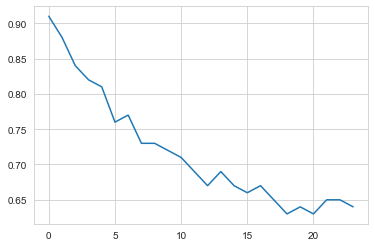

In [22]:
plt.plot(range(N_STEPS), accs)

In [24]:
accs = []
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []

    for _, row in _df.iterrows():
        try:
            x = eval(row[f'adapted h0 s{step}'])
        except TypeError:
            x = int(row[f'adapted h0 s{step}'])
        if x != -1:
            X.append(x)
            Y.append(row['target domain'])
    try:
        report, _, _ = train_and_classify(X, Y, CLF_TYPE)
    except ValueError:
        print("Not enough data to classify")

#     print(report)
    accs.append(float(report.split('accuracy')[1].split()[0]))


Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23


Text(0.5, 0, 'Adaptation step')

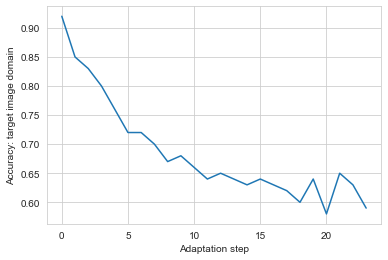

In [27]:
plt.plot(range(N_STEPS), accs)
plt.ylabel('Accuracy: target image domain')
plt.xlabel('Adaptation step')

# Is the domain of the listener encoded in $h_0$?

### Try predicting _listener_ domain from non-adapted hidden representation _using the image domain probing classifier_.  

That is, is the listener domain encoded similarly to the target domain?

In [37]:
X, Y = [], []

for _, row in id_df.iterrows():
    X.append(eval(row['original h0']))
    Y.append(row['listener domain'])

X, Y = np.array(X), np.array(Y)


print(classify(X, Y, target_classifier, target_scaler))

              precision    recall  f1-score   support

  appliances       1.00      0.99      1.00       135
        food       1.00      1.00      1.00       172
      indoor       1.00      1.00      1.00       376
     outdoor       1.00      1.00      1.00       521
    vehicles       1.00      1.00      1.00       221

    accuracy                           1.00      1425
   macro avg       1.00      1.00      1.00      1425
weighted avg       1.00      1.00      1.00      1425



In [36]:
X, Y = [], []

for _, row in ood_df.iterrows():
    X.append(eval(row['original h0']))
    Y.append(row['listener domain'])

X, Y = np.array(X), np.array(Y)


print(classify(X, Y, target_classifier, target_scaler))

              precision    recall  f1-score   support

  appliances       0.00      0.00      0.00      1289
        food       0.00      0.00      0.00      1252
      indoor       0.00      0.00      0.00      1049
     outdoor       0.00      0.00      0.00       904
    vehicles       0.00      0.00      0.00      1204

    accuracy                           0.00      5698
   macro avg       0.00      0.00      0.00      5698
weighted avg       0.00      0.00      0.00      5698



### Predict _listener_ domain from non-adapted hidden representation _using a listener domain probing classifier_.  

In [57]:
X, Y = [], []

for _, row in _df.iterrows():
    X.append(eval(row['adapted h0 s0']))
    Y.append(row['listener domain'])

X, Y = np.array(X), np.array(Y)


report, listener_classifier, listener_scaler = train_and_classify(X, Y, CLF_TYPE)
print(report)


              precision    recall  f1-score   support

  appliances       0.74      0.72      0.73      1425
        food       0.74      0.70      0.72      1424
      indoor       0.66      0.67      0.67      1424
     outdoor       0.62      0.69      0.65      1425
    vehicles       0.73      0.68      0.71      1424

    accuracy                           0.69      7122
   macro avg       0.70      0.69      0.69      7122
weighted avg       0.70      0.69      0.69      7122



### Predict _listener_ domain from adapted hidden representation (probe trained on non-adapted)

In [46]:
accs = []

for step in np.arange(N_STEPS):
    print(f'Step {step}')

    X, Y = [], []
    for _, row in id_df.iterrows():
        try:
            x = eval(row[f'adapted h0 s{step}'])
        except TypeError:
            x = int(row[f'adapted h0 s{step}'])
        if x != -1:
            X.append(x)
            Y.append(row['listener domain'])

    X, Y = np.array(X), np.array(Y)

    try:
        report = classify(X, Y, listener_classifier, listener_scaler)
        accs.append(float(report.split('accuracy')[1].split()[0]))
    except ValueError:
        print("Not enough data to classify")
        accs.append(0.)


#     print(train_and_classify(X, Y, CLF_TYPE))

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Not enough data to classify
Step 11
Not enough data to classify
Step 12
Not enough data to classify
Step 13
Not enough data to classify
Step 14
Not enough data to classify
Step 15
Not enough data to classify
Step 16
Not enough data to classify
Step 17
Not enough data to classify
Step 18
Not enough data to classify
Step 19
Not enough data to classify
Step 20
Not enough data to classify
Step 21
Not enough data to classify
Step 22
Not enough data to classify
Step 23
Not enough data to classify


Text(0.5, 0, 'Adaptation step')

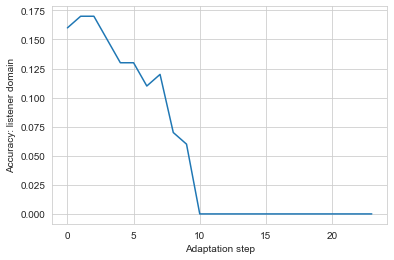

In [47]:
plt.plot(range(N_STEPS), accs)
# plt.title('Random embeddings')
plt.ylabel('Accuracy: listener domain')
plt.xlabel('Adaptation step')

In [48]:
accs = []

for step in np.arange(N_STEPS):
    print(f'Step {step}')

    X, Y = [], []
    for _, row in ood_df.iterrows():
        try:
            x = eval(row[f'adapted h0 s{step}'])
        except TypeError:
            x = int(row[f'adapted h0 s{step}'])
        if x != -1:
            X.append(x)
            Y.append(row['listener domain'])

    X, Y = np.array(X), np.array(Y)

    try:
        report = classify(X, Y, listener_classifier, listener_scaler)
        accs.append(float(report.split('accuracy')[1].split()[0]))
    except ValueError:
        accs.append(0.)
        print("Not enough data to classify")

#     print(train_and_classify(X, Y, CLF_TYPE))

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23


Text(0.5, 0, 'Adaptation step')

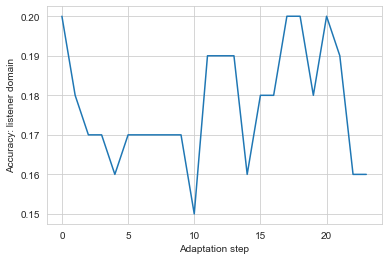

In [49]:
plt.plot(range(N_STEPS), accs)
# plt.title('Random embeddings')
plt.ylabel('Accuracy: listener domain')
plt.xlabel('Adaptation step')

### Predict _listener_ domain from adapted hidden representation (probe retrained at each step)

In [53]:
accs = []
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []
    for _, row in id_df.iterrows():
        try:
            x = eval(row[f'adapted h0 s{step}'])
        except TypeError:
            x = int(row[f'adapted h0 s{step}'])
        if x != -1:
            X.append(x)
            Y.append(row['listener domain'])
    X, Y = np.array(X), np.array(Y)

    try:
        report, _, _ = train_and_classify(X, Y, CLF_TYPE)
        accs.append(float(report.split('accuracy')[1].split()[0]))
    except ValueError:
        accs.append(0.)
        print("Not enough data to classify")


Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10


/Users/mario/code/pb_speaker_adaptation/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mario/code/pb_speaker_adaptation/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mario/code/pb_speaker_adaptation/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Not enough data to classify
Step 11
Not enough data to classify
Step 12
Not enough data to classify
Step 13
Not enough data to classify
Step 14
Not enough data to classify
Step 15
Not enough data to classify
Step 16
Not enough data to classify
Step 17
Not enough data to classify
Step 18
Not enough data to classify
Step 19
Not enough data to classify
Step 20
Not enough data to classify
Step 21
Not enough data to classify
Step 22
Not enough data to classify
Step 23
Not enough data to classify


Text(0.5, 0, 'Adaptation step')

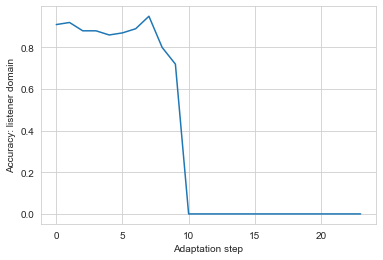

In [54]:
plt.plot(range(N_STEPS), accs)
# plt.title('Random embeddings')
plt.ylabel('Accuracy: listener domain')
plt.xlabel('Adaptation step')

In [55]:
accs = []
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []
    for _, row in _df.iterrows():
        try:
            x = eval(row[f'adapted h0 s{step}'])
        except TypeError:
            x = int(row[f'adapted h0 s{step}'])
        if x != -1:
            X.append(x)
            Y.append(row['listener domain'])
    X, Y = np.array(X), np.array(Y)

    report, _, _ = train_and_classify(X, Y, CLF_TYPE)
    accs.append(float(report.split('accuracy')[1].split()[0]))
    # print(report)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23


Text(0.5, 0, 'Adaptation step')

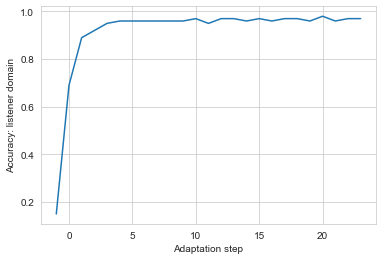

In [58]:
plt.plot(range(-1, N_STEPS), [.15] + accs)
# plt.title('Random embeddings')
plt.ylabel('Accuracy: listener domain')
plt.xlabel('Adaptation step')

# Is the adaptation itself (described as the difference between adapted and non-adapted $h_0$) predictive of listener domains?

### Predict listener domain from difference between adapted and non-adapted hidden representation (probe retrained at each step)

In [76]:
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []
    for _, row in df.iterrows():
        X.append(np.array(eval(row[f'adapted h0 s{step}'])) - np.array(eval(row['original h0'])))
        Y.append(row['listener domain'])

    X, Y = np.array(X), np.array(Y)

    report, _, _ = train_and_classify(X, Y, CLF_TYPE)
    print(report)

Step 0
              precision    recall  f1-score   support

  appliances       0.74      0.75      0.75      1289
        food       0.68      0.76      0.72      1252
      indoor       0.77      0.70      0.74      1049
     outdoor       0.75      0.71      0.73       904
    vehicles       0.74      0.72      0.73      1204

    accuracy                           0.73      5698
   macro avg       0.74      0.73      0.73      5698
weighted avg       0.73      0.73      0.73      5698

Step 1
              precision    recall  f1-score   support

  appliances       0.80      0.80      0.80      1289
        food       0.74      0.79      0.77      1252
      indoor       0.76      0.77      0.77      1049
     outdoor       0.76      0.76      0.76       904
    vehicles       0.82      0.76      0.79      1204

    accuracy                           0.78      5698
   macro avg       0.78      0.78      0.78      5698
weighted avg       0.78      0.78      0.78      5698

Step 2
 

KeyboardInterrupt: 

## Diagnostic clustering

In [ ]:
def cluster_and_plot(X, Y, k=5):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    Y_pred = kmeans.labels_
    # print(Y)

    print(f'Adjusted rand score: {adjusted_rand_score(Y_pred, Y)}')

    pca = PCA(2)
    X_2dim = pca.fit_transform(X)
    labels = np.unique(Y_pred)

    for i in labels:
        plt.scatter(X_2dim[Y_pred == i, 0], X_2dim[Y_pred == i, 1], label=i)
    plt.legend()
    plt.show()

    return kmeans, plt

### Cluster non-adapted hidden representations (vs. target domains)

In [ ]:
X, Y = [], []

for _, row in df.iterrows():
    X.append(eval(row['original h0']))
    Y.append(row['target domain'])

X, Y = np.array(X), np.array(Y)

cluster_and_plot(X, Y)

### Cluster adapted hidden representations (vs. target domains)



In [ ]:
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []

    for _, row in df.iterrows():
        X.append(eval(row[f'adapted h0 s{step}']))
        Y.append(row['target domain'])

    X, Y = np.array(X), np.array(Y)

    cluster_and_plot(X, Y)

### Cluster adapted hidden representations (vs. listener domains)


In [ ]:
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []

    for _, row in df.iterrows():
        X.append(eval(row[f'adapted h0 s{step}']))
        Y.append(row['listener domain'])

    X, Y = np.array(X), np.array(Y)

    cluster_and_plot(X, Y)

### Cluster difference between adapted and non-adapted hidden representations (vs. listener domains)


In [ ]:
for step in np.arange(N_STEPS):

    print(f'Step {step}')

    X, Y = [], []

    for _, row in df.iterrows():
        X.append(np.array(eval(row[f'adapted h0 s{step}'])) - np.array(eval(row['original h0'])))
        Y.append(row['listener domain'])

    X, Y = np.array(X), np.array(Y)

    cluster_and_plot(X, Y)